# Model 1 - Optimizing Revenue Generation

In [1]:
# Import required packages
import datetime
import os
import zipfile
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sb

In [2]:
def ceil_dt(dt, delta):
    # This function calculate the ceiling of a date-time based on given delta
    return datetime.datetime.min + math.ceil((dt - datetime.datetime.min) / delta) * delta

def round_dt(dt, delta):
    # This function calculate the ceiling of a date-time based on given delta
    return datetime.datetime.min + math.ceil((dt-delta/2 - datetime.datetime.min) / delta) * delta

def distance(gen1,gen2):
    # compute the Euclidean distance between two generations
    assert gen1.shape==gen2.shape, 'Two generation vectors should have the same length.'
    return np.sqrt(((gen1['Gen MW']-gen2['Gen MW'])** 2).sum())


In [3]:
def read_fuelmix_data(start_date='2022-01-01',end_date=None):
    # Read fuel mix data for a give date interval
    year, month, day = map(int, start_date.split('-'))
    start_date = datetime.date(year, month, day)  # Ending date
    if end_date==None:
        end_date=start_date
    else:
        end_date=datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
        
    
    fuelmix=pd.DataFrame()
    while start_date <= end_date:
        month_folder='../Data/2022_NYISO_fuelmix/'+str(start_date.strftime('%Y%m'))+'01rtfuelmix_csv'
        file_name=str(start_date.strftime('%Y%m%d'))+'rtfuelmix.csv'
        # Check if the month folder exists, otherwise unzip the zipped month data folder
        if not os.path.exists(month_folder):
            with zipfile.ZipFile(month_folder+'.zip', 'r') as zip_ref:
                zip_ref.extractall(month_folder)


        # Read data from csv file
        cur_fuelmix = pd.read_csv(month_folder+"/"+file_name)
        
        # Append the current date fuel mix data to the fuelmix data frame
        fuelmix=fuelmix.append(cur_fuelmix)
        start_date +=datetime.timedelta(days=1)
        
    fuelmix=fuelmix.reset_index(drop=True)
    
    return fuelmix


def calc_avg_fuelmix(input_fuelmix,delta_t=5,method='ceil'):
    
    assert delta_t>=5, 'Time resolution must be at least 5 minutes.'
    assert delta_t<=60, 'Time resolution must be at most 60 minutes.'
    assert delta_t % 5==0, 'Time resolution must be a multipicant of 5 minutes.'
    time_resolution = datetime.timedelta(minutes=delta_t)
    fmix=input_fuelmix
    # For each time stamp, create an 'Agg Time Stamp' which is the ceiling or round of 
    # the time stamp with delta_t (depending on the provided method)
    if method=='ceil':
        fmix['Agg Time Stamp']=fmix['Time Stamp'].apply(lambda x: ceil_dt(datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S'),time_resolution))
    elif method=='round':
        fmix['Agg Time Stamp']=fmix['Time Stamp'].apply(lambda x: round_dt(datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S'),time_resolution))
    
    # For each 'Agg Time Stamp' and 'Fuel Category' calculate the mean Power Gen (MW)
    # Then, change the column 'Agg Time Stamp' name to 'Time Stamp'
    fmix_avg = fmix.groupby(['Agg Time Stamp','Fuel Category']).mean().reset_index().rename(columns={'Agg Time Stamp': 'Time Stamp'})
    
    # Create 'Date' and 'Time' columns based on 'Time Stamp'
    fmix_avg['Date']=pd.to_datetime(fmix_avg['Time Stamp']).dt.date
    fmix_avg['Time']=pd.to_datetime(fmix_avg['Time Stamp']).dt.strftime('%H:%M')
    return fmix_avg



In [4]:
def preliminary_analysis(start_date='2022-01-01',end_date=None):
    # The purpose of this part is to explore the raw data and check its consistency.
    if end_date==None: end_date=start_date
        
    fuelmix=read_fuelmix_data(start_date,end_date)
    fuelmix['Date']=pd.to_datetime(fuelmix['Time Stamp']).dt.date
    fuelmix['Time']=pd.to_datetime(fuelmix['Time Stamp']).dt.strftime('%H:%M:%S')
    fuelmix.groupby(['Date','Fuel Category']).count()['Time Stamp']
    print('Raw fuelmix data for the given date interval\n',fuelmix)
    
    delta_t=5
    fuelmix_avg=calc_avg_fuelmix(fuelmix,delta_t=delta_t)
    datacount=fuelmix_avg.groupby('Date').count()['Time Stamp'].rename('count').reset_index()
    print('Dates with abnormal data counts when we ceil the time stamps to the next', delta_t ,' minute\n',datacount[datacount['count']<24*60*7/delta_t])


    
    fuelmix_avg=calc_avg_fuelmix(fuelmix,delta_t=delta_t,method='round')
    datacount=fuelmix_avg.groupby('Date').count()['Time Stamp'].rename('count').reset_index()
    print('Dates with abnormal data counts when we round the time stamps to the nearest', delta_t ,' minute\n',datacount[datacount['count']<24*60*7/delta_t])

preliminary_analysis('2022-01-01','2022-12-31')

Raw fuelmix data for the given date interval
                  Time Stamp Time Zone       Fuel Category  Gen MW        Date  \
0       01/01/2022 00:05:00       EST           Dual Fuel  2811.0  2022-01-01   
1       01/01/2022 00:05:00       EST         Natural Gas  1946.0  2022-01-01   
2       01/01/2022 00:05:00       EST             Nuclear  3337.0  2022-01-01   
3       01/01/2022 00:05:00       EST  Other Fossil Fuels     3.0  2022-01-01   
4       01/01/2022 00:05:00       EST    Other Renewables   245.0  2022-01-01   
...                     ...       ...                 ...     ...         ...   
756303  01/01/2023 00:00:00       EST             Nuclear  3344.0  2023-01-01   
756304  01/01/2023 00:00:00       EST  Other Fossil Fuels     5.0  2023-01-01   
756305  01/01/2023 00:00:00       EST    Other Renewables   238.0  2023-01-01   
756306  01/01/2023 00:00:00       EST                Wind   943.0  2023-01-01   
756307  01/01/2023 00:00:00       EST               Hydro  2841

# Some Data Issues

It is expected to have 24*12*7=2016 data values in each date, considering one data point every 5 minutes for 7 fuel categories. However, for 2022-01-01, there are only 2009 data values because there is no value recorded at the exact time of 2022-01-01 00:00:00. Because the last time stamp of '2022-01-01' is reported as '2022-01-02 00:00:00'

For '2023-01-01', we have only 2023-01-01 00:00:00, which is expected because it is corresponding to the last time stamp of 2022-12-31'.

There are more serious anomalies for other days. For example, for 2022-01-03, there are data points for 07:50:01 and 07:51:13 instead of the expected data point for 07:50:00. These anomalies result in different numbers of values for each Fuel Category in each date.

We first tried to ceil the time stamps to the next time tick given a time resolutin of 5 minutes. But, even after that, we saw 22 dates (other than 2022-01-01 and 2023-01-01) with abnormal number of data counts. Finally, we rounded the time stamps to the nearest 5 minute tick (instead of ceiling them). This case resulted only in the following 6 cases:
        Date  count
  2022-03-13   1932
  2022-04-19   1995
  2022-06-02   2009
  2022-11-05   2009
  2022-12-27   2002
  2022-12-28   2009
  These abnormal cases were not considered to typical days.
  
  We also observed that from 03/13/2022 03:00:00 to 11/06/2022 01:55:00 data is given in EDT Time Zone and for the rest it is EST Time Zone.
  
  

In [5]:
def calc_avg_typical(fuelmix_avg,start_date='2022-01-01',end_date='2022-12-31',delta_t=5):
    # Calculate the average and typical power generation days
    # Then calculate the corresponding emission
    
    # For every time stamp, calculate the sum of power and emission over different fuel categories.
    total_gen=fuelmix_avg.groupby('Time Stamp')[['Gen MW','Emission (kgCO2e)']].sum().reset_index()

    # Create 'Date' and 'Time' columns based on 'Time Stamp'
    total_gen['Date']=pd.to_datetime(total_gen['Time Stamp']).dt.date
    total_gen['Time']=pd.to_datetime(total_gen['Time Stamp']).dt.strftime('%H:%M')
    
    
    print('Total power generation and emission in each time stamp:\n',total_gen)

    # Calculate the average day power generation and emission
    average_day_gen=total_gen.groupby('Time')['Gen MW'].mean()
    average_day_gen=average_day_gen[1:].append(average_day_gen[:1]).reset_index()
    average_day_emission=total_gen.groupby('Time')['Emission (kgCO2e)'].mean().reset_index()
    NT=average_day_gen.shape[0]


    # To find a typical day, compare each day's generation and find the one which is the closest 
    # to the average day generation. Here we used the Euclidean norm between two generations to measure distance.
    year, month, day = map(int, start_date.split('-'))
    start_date = datetime.date(year, month, day)  
    end_date=datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    
    least_distance_gen=np.sqrt((average_day_gen['Gen MW']** 2).sum())
    while start_date <= end_date:
        cur_day_gen=(total_gen[['Time','Gen MW']][total_gen['Date']==start_date][1:].append(
            total_gen[['Time','Gen MW']][total_gen['Date']==start_date+datetime.timedelta(days=1)][:1])).reset_index(drop=True)
        if cur_day_gen.shape[0]==NT:
            cur_distance_gen=distance(average_day_gen,cur_day_gen)
            if least_distance_gen>cur_distance_gen:
                least_distance_gen=cur_distance_gen
                typical_day_gen=cur_day_gen
                typical_day=start_date
        start_date +=datetime.timedelta(days=1)

    
    print(typical_day,' is a typical day for generation.')
    total_generation=pd.DataFrame()
    
    
    # Prepare the outputs of this function including generation, emission and 
    # emission factor for the average and typical days
    total_generation['Average Day']=average_day_gen['Gen MW']
    total_generation['Typical Day']=typical_day_gen['Gen MW']
    total_generation=total_generation.set_index(average_day_gen['Time'])


    typical_day_emission=(total_gen[['Time','Emission (kgCO2e)']][total_gen['Date']==typical_day][1:].append(
            total_gen[['Time','Emission (kgCO2e)']][total_gen['Date']==typical_day+datetime.timedelta(days=1)][:1])).reset_index(drop=True)
    total_emission=pd.DataFrame()
    total_emission['Average Day']=average_day_emission['Emission (kgCO2e)']
    total_emission['Typical Day']=typical_day_emission['Emission (kgCO2e)']
    total_emission=total_emission.set_index(average_day_emission['Time'])
    
    
    total_emission_factor=pd.DataFrame()
    total_emission_factor['Average Day']=(60)/(1000*delta_t)*total_emission['Average Day']/total_generation['Average Day']
    total_emission_factor['Typical Day']=(60)/(1000*delta_t)*total_emission['Typical Day']/total_generation['Typical Day']
    total_emission_factor=total_emission_factor.set_index(total_generation.index)
    
    # Calculate the  average day generation and emission by fuel categories 
    average_day_genmix=fuelmix_avg.groupby(['Time','Fuel Category'])['Gen MW'].mean().reset_index()
    average_day_emissionmix=fuelmix_avg.groupby(['Time','Fuel Category'])['Emission (kgCO2e)'].mean().reset_index()
    average_day_genmix=average_day_genmix.pivot_table(values='Gen MW', index='Time', columns='Fuel Category')
    average_day_emissionmix=average_day_emissionmix.pivot_table(values='Emission (kgCO2e)', index='Time', columns='Fuel Category')
    
    
    
    return total_generation, total_emission,total_emission_factor,average_day_genmix,average_day_emissionmix


In [6]:
def main_fuelmix_alg(start_date='2022-01-01',end_date='2022-12-31',delta_t=5):
    # delta_t is the time resolution in minutes
    
    # Read fuel mix data
    fuelmix=read_fuelmix_data(start_date,end_date)
    #fuelmix.to_excel('fuelmix.xlsx')
    
    # Aggregate data with the give time resolution of delta_t
    fuelmix_avg=calc_avg_fuelmix(fuelmix,delta_t=delta_t,method='round')
    
    
    # Add a new column showing Emission (kgCO2e) for each time stamp and fuel category 
    emission_data=pd.DataFrame({'Fuel Category':['Dual Fuel', 'Hydro', 'Natural Gas', 'Nuclear', 'Other Fossil Fuels', 'Other Renewables', 'Wind'],
                                'Emission Factor':[0.444, 0, 0.426, 0, 0.935, 0.256, 0]})
    fuelmix_avg=pd.merge(fuelmix_avg,emission_data,on='Fuel Category')
    fuelmix_avg['Emission (kgCO2e)']=1000*fuelmix_avg['Gen MW']*fuelmix_avg['Emission Factor']*delta_t/60
    #fuelmix_avg.to_excel('fuelmix_avg.xlsx')
    
    
    pivot_table = fuelmix_avg.pivot_table(values='Gen MW', index='Time', columns='Date')
    # create heatmap of power generation
    plt.figure(figsize=(18, 10))
    sb.heatmap(pivot_table.iloc[::-1],cmap='YlOrRd')
    plt.ylabel('Time of Day')
    plt.title('Heat Map of Power Generation (GW)')
    plt.savefig('Heatmap_gen.png')
    
    pivot_table = fuelmix_avg.pivot_table(values='Emission (kgCO2e)', index='Time', columns='Date')
    # create heatmap of emission
    plt.figure(figsize=(18, 10))
    sb.heatmap(pivot_table.iloc[::-1],cmap='YlOrRd')
    plt.ylabel('Time of Day')
    plt.title('Heat Map of Emission (kgCO2e)')
    plt.savefig('Heatmap_emission.png')
    
    # find the average and typical day generation, emission, and emission factor
    total_generation, total_emission,total_emission_factor,average_day_genmix,average_day_emissionmix=calc_avg_typical(fuelmix_avg,start_date,end_date,delta_t)
    
    # Format the y-axis ticks to show values in 1000s where needed
    y_fmt = mtick.FuncFormatter(lambda val, pos: '{:.0f}K'.format(val/1000))
    
    
    # Plot the outputs and save the plots
    total_generation.plot(figsize=(15,8)).yaxis.set_major_formatter(y_fmt)
    plt.title('Average and Typical Day Generations')
    plt.ylabel('Generated Power (MW)')
    plt.savefig('Avg_Typical_Generation.png')

    
    total_emission.plot(figsize=(15,8)).yaxis.set_major_formatter(y_fmt)
    plt.title('Average and Typical Day Emissions')
    plt.ylabel('Emission (kgCO2e)')
    plt.savefig('Avg_Typical_Emission.png')
    
    
    
    total_emission_factor.plot(figsize=(15,8))
    plt.title('Average and Typical Day Emission Factors')
    plt.ylabel('Emission Factor (kgCO2e/KWh)')
    plt.savefig('Avg_Typical_Em_Factor.png')
    
    
    average_day_genmix.plot(kind='area',stacked=True,figsize=(15,8)).yaxis.set_major_formatter(y_fmt)
    plt.title('Average Day Generation by Fuel Category')
    plt.ylabel('Generated Power (MW)')
    plt.savefig('Avg_Day_Gen_by_Fuel.png')
    
    average_day_emissionmix.plot(kind='area',stacked=True,figsize=(15,8)).yaxis.set_major_formatter(y_fmt)
    # Format the y-axis ticks to show values in 1000s
    y_fmt = mtick.FuncFormatter(lambda val, pos: '{:.0f}K'.format(val/1000))
    plt.title('Average Day Emission by  Fuel Category')
    plt.ylabel('Emission (kgCO2e)')
    plt.savefig('Avg_Day_Emission_by_Fuel.png')

Total power generation and emission in each time stamp:
                 Time Stamp   Gen MW  Emission (kgCO2e)        Date   Time
0      2022-01-01 00:05:00  11608.0      178550.416667  2022-01-01  00:05
1      2022-01-01 00:10:00  11591.0      179388.083333  2022-01-01  00:10
2      2022-01-01 00:15:00  11584.0      179532.083333  2022-01-01  00:15
3      2022-01-01 00:20:00  11579.0      179234.916667  2022-01-01  00:20
4      2022-01-01 00:25:00  11512.0      177806.916667  2022-01-01  00:25
...                    ...      ...                ...         ...    ...
105095 2022-12-31 23:40:00  12586.0      195660.083333  2022-12-31  23:40
105096 2022-12-31 23:45:00  12551.0      193139.416667  2022-12-31  23:45
105097 2022-12-31 23:50:00  12480.0      190964.916667  2022-12-31  23:50
105098 2022-12-31 23:55:00  12459.0      190308.250000  2022-12-31  23:55
105099 2023-01-01 00:00:00  12498.0      191166.916667  2023-01-01  00:00

[105100 rows x 5 columns]
2022-05-13  is a typical day

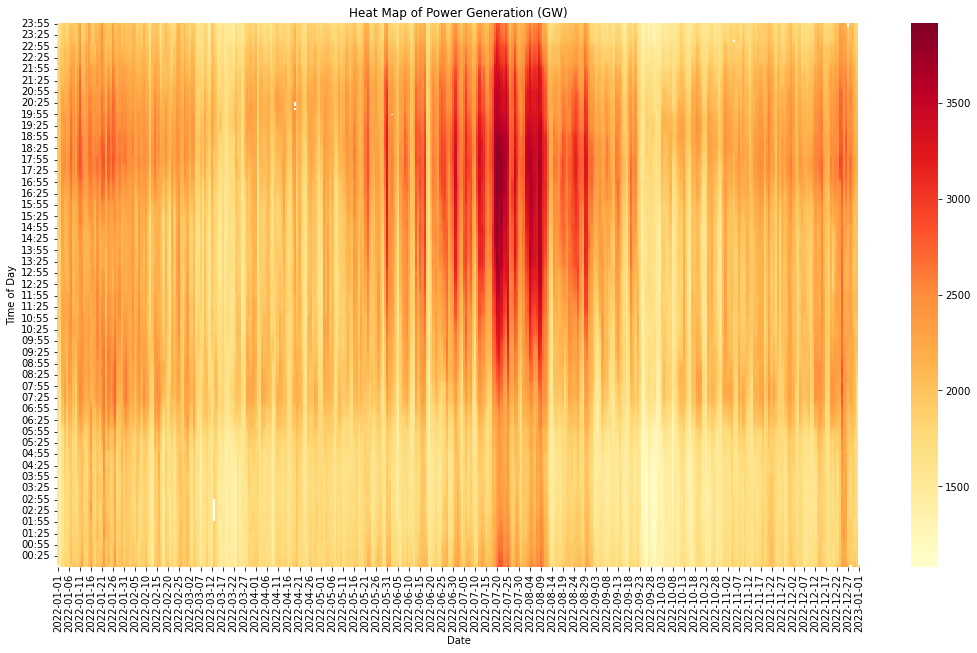

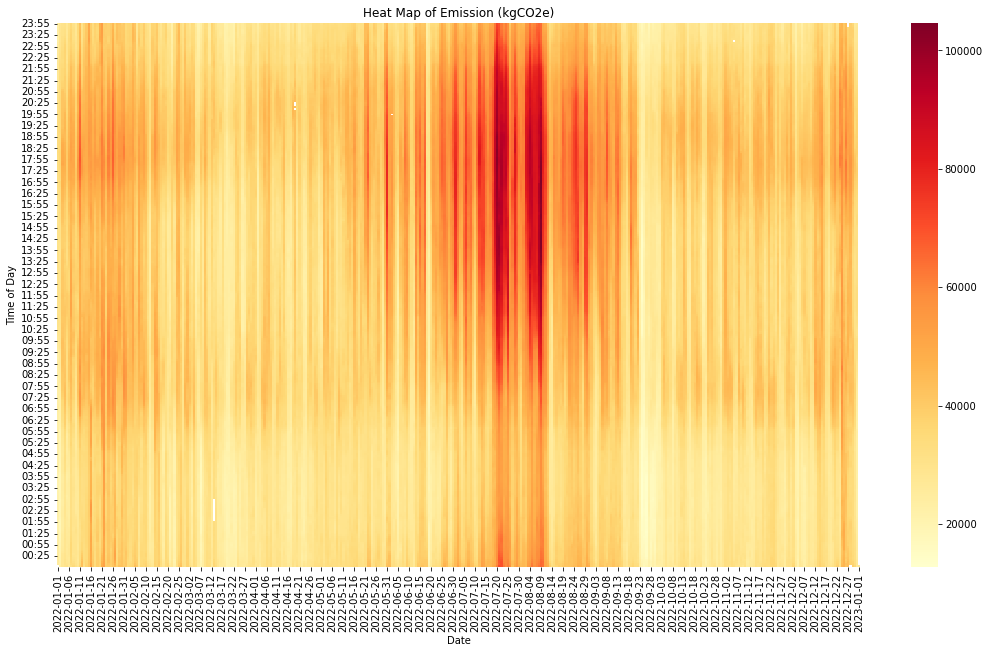

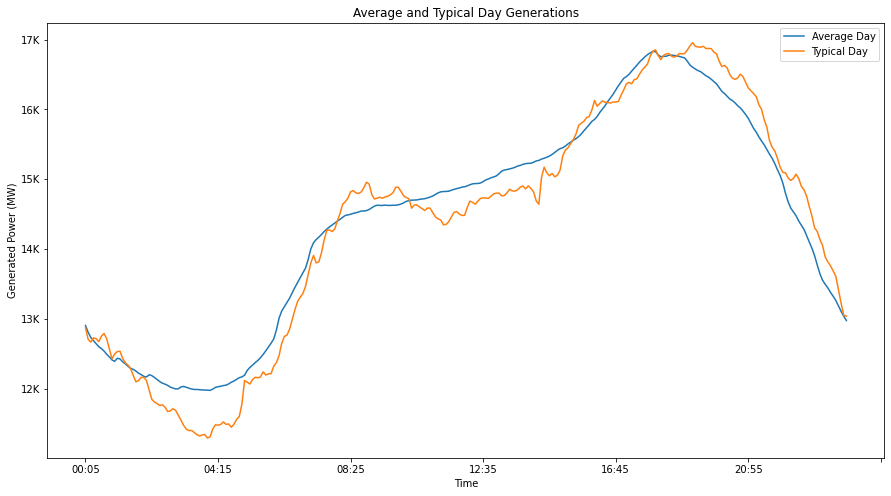

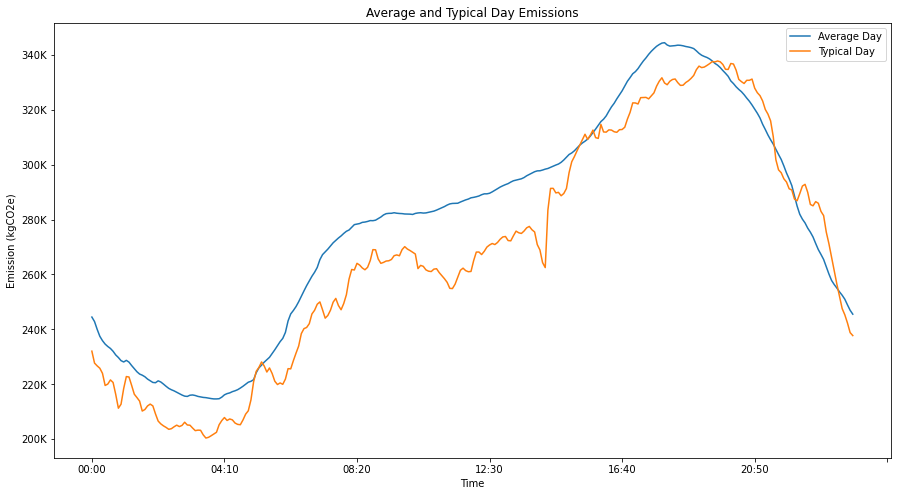

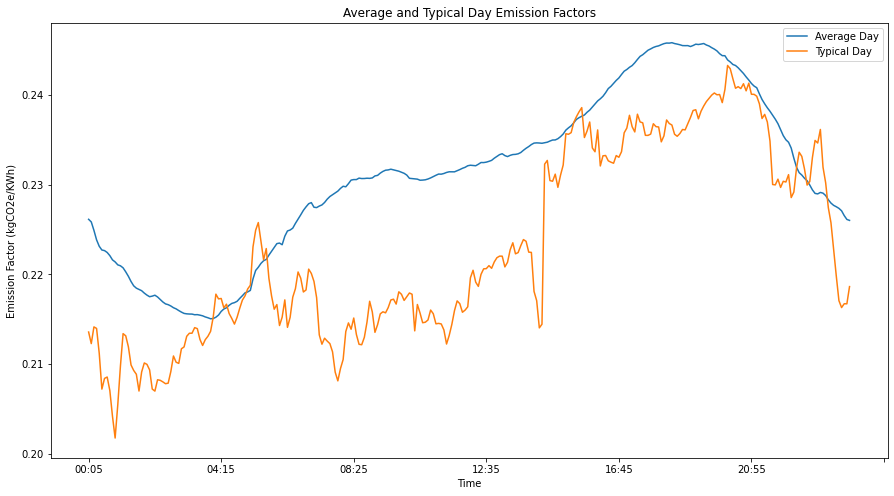

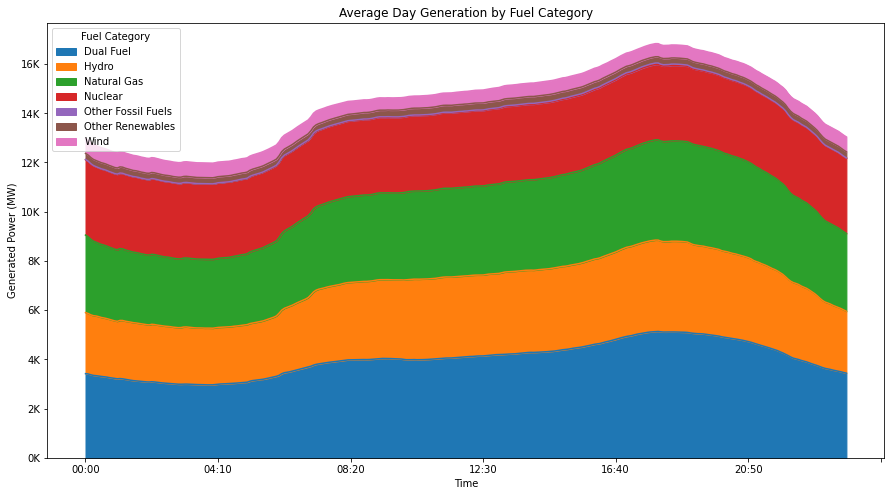

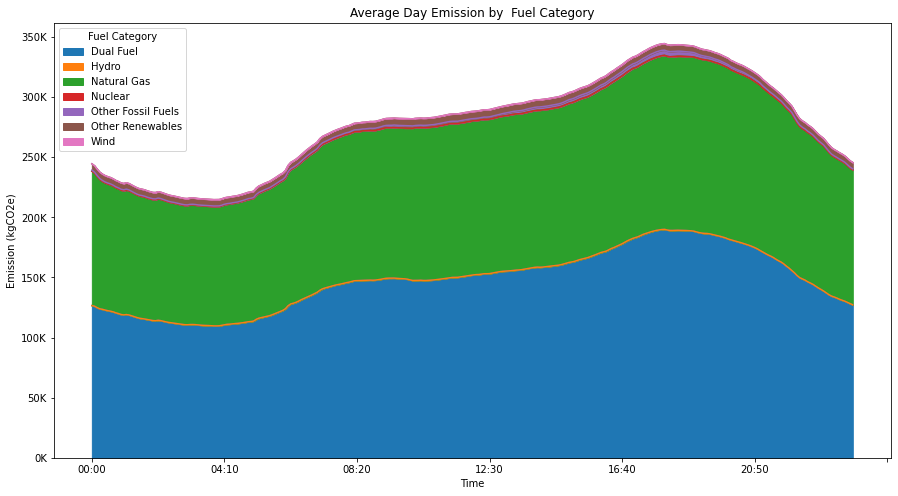

In [7]:
main_fuelmix_alg(start_date='2022-01-01',end_date='2022-12-31',delta_t=5)

# Insights 
Analysis of the power generation heatmap reveals that the diurnal power generation pattern is characterized by a peak in the late afternoon and evening hours (between 4:00 PM and 8:00 PM) throughout most of the year. An additional peak is observed in the morning hours around 8:00 AM on certain days. However, during the months of July and August, power generation exhibits a pronounced increase relative to the other months. During these months, the highest levels of power generation occur from 7:00 AM to midnight, with peak generation occurring during the afternoon hours. It is plausible that this surge in power demand and generation can be attributed to the amplified use of air conditioning systems during the summer season. Additionally, the longer daylight duration during the summer months may also contribute to the increased power demand and generation. A similar pattern is observed from the emission heatmap.

## Average Day
Based on the average day generation plot, it can be observed that the minimum average generation occurs at around 4:00 AM. From 5:00 AM, there is a sharp increase in average generation, which continues until 8:00 AM. After 8:00 AM, the increase in average generation continues linearly but with a lower slope until 5:00 PM. From 5:00 PM, there is a rapid increase in average generation until it reaches its peak around 7:00 PM. After 7:00 PM, there is a sharp decrease in average generation until the next morning. Overall, the average day generation plot shows a distinct diurnal pattern, with a gradual increase in generation throughout the morning and early afternoon, followed by a sharp increase in the late afternoon and early evening, and then a sharp decrease at night.


## Typical Day
To determine a typical day for power generation, each day's generation was compared with the average day generation using the Euclidean norm as the distance metric. The day with the closest generation pattern to the average day was identified as the typical day, which was found to be May 13th, 2022. While the average and typical day plots exhibit similar trends, the typical day features more extreme peaks and valleys compared to the average day. The ramp up and ramp down rates are also sharper in the typical day. In addition, the typical day displays two distinct peaks, one around 9:00 AM and the other around 8:00 PM, with a relatively flat or decreasing period observed between 9:00 AM and 4:00 PM.

## Average and Typical Day Emissions
The emissions plots for the average and typical days exhibit similar trends, with the typical day showing lower emissions overall compared to the average day. Additionally, the emissions plots follow similar patterns to the corresponding power generation plots.

## Average Emission Factors
By dividing the total emission to the total generation of each time stamp we can find the average emission factor for that time stamp in (kgCO2e/KWh). The average and typical day emission factor plots indicate that the emission factor increases during peak generation times (by approximately 15% above its minimum value). This means that during peak times, both the generation and the emission factor increase, resulting in a doubly increased emission. This suggests that during peak times, the system is forced to rely more heavily on high pollutant resources, leading to increased emissions. This suggests to investigate the generation and emission by fuel categories.

## Generation and Emission by Fuel Categories
The plots for average day generation and emission by fuel category reveal that NYISO primarily relies on dual fuel, natural gas, and hydro units to adjust generation based on demand. Hydro units have zero emissions, but dual fuel and natural gas, with emission factors of 0.444 and 0.426 kgCO2e/KWh, respectively, play a significant role in increasing emissions during peak hours. Furthermore, the "other fossil fuels" category, which has the highest emission factor among all 7 fuel categories at 0.935 kgCO2e/KWh, is not used much during the day, but it is utilized during peak times. This implies that the system relies on the high-emitting "other fossil fuels" to meet the demand during peak hours when other sources may not be sufficient.

It should be noted that the generation from nuclear sources appears to remain almost constant throughout the day, according to the available data. Additionally, while wind and other renewable sources do contribute to the overall generation, they currently comprise only a relatively small percentage of the total generation.




# Suggestions

Some suggestions for further study based on the the fuel mix data set and the results are:

1. Investigate the impact of weather on power generation and emissions, particularly during extreme weather events such as heatwaves or cold snaps. This could help to identify strategies for mitigating the environmental impact of such events.
2. Analyze the impact of different policy interventions, such as carbon pricing or renewable energy mandates, on the emissions profile of the NYISO grid. This could provide insights into the most effective policy tools for reducing emissions from power generation.
3. Consider the impact of changes in demand patterns, such as the increased use of electric vehicles or the adoption of distributed renewable energy systems, on the emissions profile of the NYISO grid. This could help to identify potential challenges and opportunities for decarbonizing the power sector.
4. Investigate the feasibility and impact of different energy storage technologies, such as batteries or pumped hydro storage, on the emissions profile of the NYISO grid. It should be taken into account that emission factors tend to be lower during off-peak periods. Therefore, by effectively storing energy during these periods and utilizing it during peak hours, it is possible not only to generate revenue but also to decrease overall emissions.